In [56]:
import desitarget.io
import desitarget.mtl
import desimodel.io
import fitsio
import sys
import os
from astropy.table import Table,vstack,unique,join
import numpy as np
import desisim.quickcat
import glob
from matplotlib import pyplot as plt

In [44]:
runs = [0,1,2,3]
ldir = os.environ['CSCRATCH']+'/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/'

In [14]:
if not os.path.exists(os.environ['CSCRATCH']+'/testledgers/fiberassign'):
    os.mkdir(os.environ['CSCRATCH']+'/testledgers/fiberassign')

In [45]:
for run in runs:
    tileff = '/global/cfs/cdirs/desi/datachallenge/onepercent/catalogs/dark/e2etiles_run'+str(run)+'.fits'
    tilef = fitsio.read(tileff)
    #tilef = desimodel.io.load_tiles(tilesfile='/global/cfs/cdirs/desi/datachallenge/onepercent/catalogs/dark/e2etiles_run0.fits') #not sure why this doesn't work
    tars = desitarget.io.read_targets_in_tiles(ldir, tiles=tilef, mtl=True, unique=True)
    print('found '+str(len(tars))+' targets')
    tarf = os.environ['CSCRATCH']+'/testledgers/darktar'+str(run)+'.fits'
    fitsio.write(tarf,tars)
    skies = desitarget.io.read_targets_in_tiles('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/skies',tiles=tilef)
    skyf = os.environ['CSCRATCH']+'/testledgers/skies.fits'
    fitsio.write(skyf,skies)
    fapath = os.environ['CSCRATCH']+'/testledgers/fiberassign/'+str(run)
    if not os.path.exists(fapath):
        os.mkdir(fapath)    
    fba_run = 'fba_run --targets {} --sky {} --footprint {}  --dir {} --rundate 2020-01-01T00:00:00 --overwrite'.format(
                tarf, skyf, tileff, fapath)
    print(fba_run)
    os.system(fba_run)   
    tars = Table.read(tarf)
    #truth info for zcat, actual values don't matter for this test
    tars['TRUEZ'] = np.random.random(len(tars))
    tars['TRUETYPE'] = 'GALAXY'
    tars['TRUESPECTYPE'] = 'GALAXY'
    fba_files = np.sort(glob.glob(os.path.join(fapath,"fba-*.fits")))
    if run == 0:
        zcat = desisim.quickcat.quickcat(fba_files, tars, tars, fassignhdu='FASSIGN', perfect=True)
    else:  
        old_zcat = Table.read(old_zcat_filename)
        zcat = desisim.quickcat.quickcat(fba_files, tars, tars, fassignhdu='FASSIGN', zcat=old_zcat, perfect=True)
    old_zcat_filename = os.environ['CSCRATCH']+'/testledgers/zcat'+str(run)+'.fits'
    zcat.write(old_zcat_filename, overwrite=True)
    print('run '+str(run)+' done')
    print('the zcat contains this many entries: '+str(len(zcat)))

found 678179 targets
fba_run --targets /global/cscratch1/sd/ajross/testledgers/darktar0.fits --sky /global/cscratch1/sd/ajross/testledgers/skies.fits --footprint /global/cfs/cdirs/desi/datachallenge/onepercent/catalogs/dark/e2etiles_run0.fits  --dir /global/cscratch1/sd/ajross/testledgers/fiberassign/0 --rundate 2020-01-01T00:00:00 --overwrite
INFO:quickcat.py:592:quickcat: Mon Feb 22 14:23:51 2021 QC Reading 39 tiles
INFO:quickcat.py:636:quickcat: Mon Feb 22 14:23:51 2021 QC Trimming truth to just observed targets
INFO:quickcat.py:643:quickcat: Mon Feb 22 14:23:52 2021 QC Constructing new redshift catalog
INFO:quickcat.py:655:quickcat: Mon Feb 22 14:23:52 2021 QC Adding ZERR and ZWARN
INFO:quickcat.py:673:quickcat: Mon Feb 22 14:23:52 2021 QC Adding NUMOBS column
INFO:quickcat.py:679:quickcat: Mon Feb 22 14:23:52 2021 QC Merging previous zcat
INFO:quickcat.py:726:quickcat: Mon Feb 22 14:23:52 2021 QC done
run 0 done
the zcat contains this many entries: 169756
found 111604 targets
fba_

In [46]:
for run in runs:
    tileff = '/global/cfs/cdirs/desi/datachallenge/onepercent/catalogs/dark/e2etiles_run'+str(run)+'.fits'
    tilef = fitsio.read(tileff)
    print(len(tilef))


39
4
3
5


In [47]:
f = fitsio.read('/global/cscratch1/sd/ajross/testledgers/zcat3.fits')
f.dtype.names

('TARGETID', 'BRICKNAME', 'SPECTYPE', 'Z', 'ZERR', 'ZWARN', 'NUMOBS')

In [53]:
#stack targets, match with zcat
t0 = Table.read(os.environ['CSCRATCH']+'/testledgers/darktar0.fits')
for ii in range(1,4):
    tn = Table.read(os.environ['CSCRATCH']+'/testledgers/darktar'+str(ii)+'.fits')
    t0 = vstack([t0,tn])
t0 = unique(t0,keys=['TARGETID'])  
t0.keep_columns(['RA','DEC','TARGETID','DESI_TARGET'])
zj = join(f,t0,keys=['TARGETID'])

In [54]:
zj.columns

<TableColumns names=('TARGETID','BRICKNAME','SPECTYPE','Z','ZERR','ZWARN','NUMOBS','RA','DEC','DESI_TARGET')>

In [23]:
skies = desitarget.io.read_targets_in_tiles('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/skies',tiles=tilef)

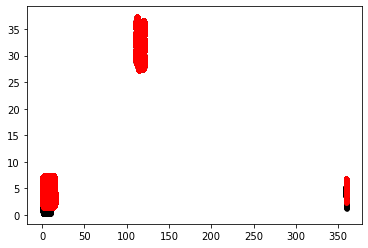

In [60]:
plt.plot(zj['RA'],zj['DEC'],'k.')
plt.plot(zj0['RA'],zj0['DEC'],'r.')

In [58]:
len(zj)




192487

In [59]:
f0 = fitsio.read('/global/cscratch1/sd/ajross/testledgers/zcat0.fits')
zj0 = join(f0,t0,keys=['TARGETID'])

In [39]:
#targets : astropy Table of targets
#truth : astropy Table of input truth with columns TARGETID, TRUEZ, and TRUETYPE

INFO:quickcat.py:592:quickcat: Mon Feb 22 13:27:53 2021 QC Reading 39 tiles
INFO:quickcat.py:636:quickcat: Mon Feb 22 13:27:55 2021 QC Trimming truth to just observed targets
INFO:quickcat.py:643:quickcat: Mon Feb 22 13:27:55 2021 QC Constructing new redshift catalog
INFO:quickcat.py:655:quickcat: Mon Feb 22 13:27:56 2021 QC Adding ZERR and ZWARN
INFO:quickcat.py:673:quickcat: Mon Feb 22 13:27:56 2021 QC Adding NUMOBS column
INFO:quickcat.py:679:quickcat: Mon Feb 22 13:27:56 2021 QC Merging previous zcat
INFO:quickcat.py:726:quickcat: Mon Feb 22 13:27:56 2021 QC done


In [43]:
desitarget.mtl.update_ledger(ldir, tars, zcat)

INFO:mtl.py:230:make_mtl: 162712 of 678179 targets have priority zero, setting N_obs=0.
INFO:mtl.py:293:make_mtl: Done...t=2.4s


In [62]:
f.readline()

'#   OBSCON: DARK, SURVEY: main}\n'

In [63]:
f = open(os.environ['CSCRATCH']+'/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/mtl-dark-hp-3151.ecsv')
keyword = 'OBSCON'
for line in f:
    if keyword in line and 'name' not in line:
        break
ls = line.split(',')
for ii in range(0,len(ls)):
    if keyword in ls[ii]:
        keyval = ls[ii].split(':')[1].split("}")[0]
print(keyval)


 DARK


In [10]:
desitarget.io.read_targets_header(ldir)

INFO:io.py:3282:read_targets_header: no FITS files in /global/cscratch1/sd/ajross/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/?!


OSError: FITSIO status = 108: error reading from FITS file
Error reading data buffer from file:
/global/cscratch1/sd/ajross/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/
ffopen could not interpret primary array header of file: 
/global/cscratch1/sd/ajross/testledgers/dr9/0.50.0.dev4501/mtl/main/dark/


In [11]:
desitarget.io.hpdirname

AttributeError: module 'desitarget.io' has no attribute 'hpdirname'